<div style="border:solid darksalmon 2px; padding: 20px">
<h2 style="color: darkslategray">Recommendation of the suitable active tariff for customers</h2>
   
Mobile operator "Megaline" has found out that many customers are still using the archive tariffs. They want to build a system that can analyze customer behavior and offer users a new plan: "Smart" or "Ultra".

As a source for the forthcoming analysis we have data on the behavior of customers who have already switched to these tariffs.
    
**Project Objective:** Build a classification model that selects the appropriate tariff for the customer with the highest accuracy value (aiming for an accuracy rate of at least 0.75).

**Research Process**
    
The research will be conducted in 6 stages:
 1. Data overview.
 2. Data splitting.
 3. Model exploration.
 4. Model evaluation on the test set.
 5. Model adequacy check.
 6. Overall conclusion regarding the results of the analysis.
    
<img src="https://img.freepik.com/free-vector/curiosity-people-concept-illustration_114360-11034.jpg" width="300" height="300" alt="illustration" />

## Data overview

* Calls - the number of calls,
* minutes - total duration of calls in minutes,
* messages - number of SMS messages,
* mb_used - used internet traffic in Mb,
* is_ultra - which tariff plan was used during the month ("Ultra" - 1, "Smart" - 0).

Each object in the dataset is information about the behavior of one user per month. 

## Getting ready for work

In [1]:
# load libraries

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV

## General Information Study

In [2]:
# read the data file and store it in the df variable

df = pd.read_csv('./users_behavior.csv')

In [3]:
# prints the first 5 lines of the dataframe

df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


We can see that we have a total of 5 features available, the columns have correct names, and all the data is numerical.

In [4]:
# prints general information about the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


There are no missing values in the data.

In [5]:
# let's display the information with the characteristics of the features

df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Based on the obtained list of characteristic values and judging by std (standard deviation) values, we can note that our variables have a significant spread, indicating the presence of anomalies and outliers in the dataset.

Let's visualize the distribution of values in our dataframe and examine the relationships between all pairs of variables.

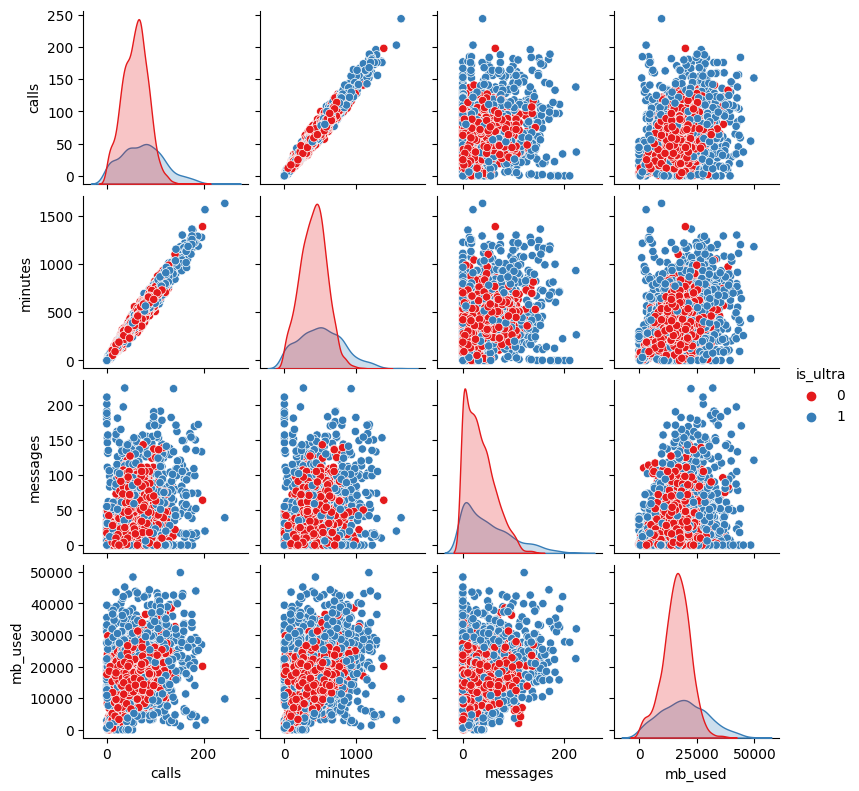

In [6]:
# use the pairplot() function to visualize the graph

_ = sns.pairplot(df, hue='is_ultra', palette='Set1', height=2)

Data visualization reveals that there are more customers with the "Smart" tariff in our dataframe than customers with the "Ultra" tariff. Additionally, we can observe a strong linear relationship between the **calls** and **minutes** features. Thus, we have identified the presence of imbalanced observations and multicollinearity in the dataset.

Let's examine the class imbalance in relative terms:

In [ ]:
# Let's calculate the percentage of Smart and Ultra subscribers

round(df['is_ultra'].value_counts()/len(df) * 100)

In our dataframe 69% of customers have the "Smart" tariff, while 31% have the "Ultra" tariff.

Class imbalance can occur due to the presence of duplicates in the dataset. We will check for explicit duplicates using the "duplicated()" method.

In [ ]:
# Returns the number of duplicates

df.duplicated().sum()

No explicit duplicates have been found.

Despite the class imbalance, considering that we are dealing with a binary classification task, the explored models are likely to be weakly dependent on class balance. Therefore, we will not address the class imbalance issue and will use the "stratify" argument when splitting the data, which will maintain the original distribution of the target feature in all new datasets.

Let's revisit the earlier identified multicollinearity in our dataframe and visualize the correlation matrix using a heatmap.

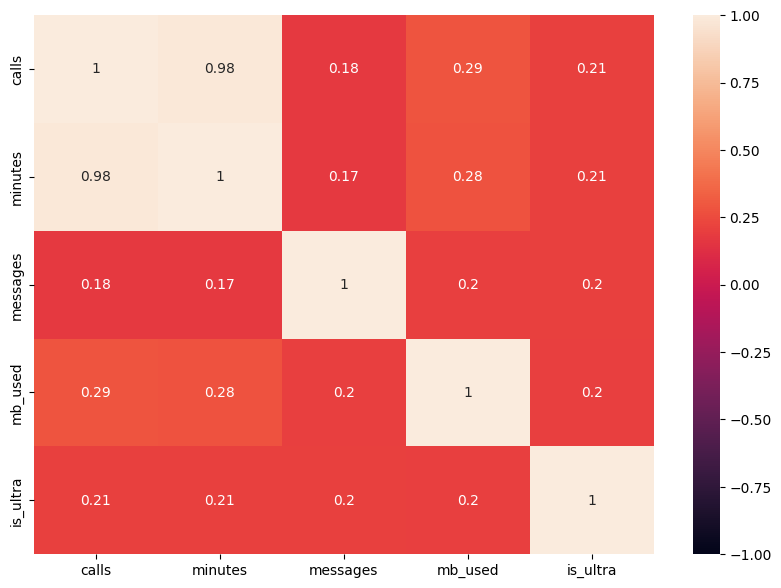

In [9]:
# Graph showing the direct relationship between variables

fif, ax = plt.subplots(figsize=(10, 7))
_ = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, ax=ax)

According to the obtained graph, we can observe a strong positive correlation between the **calls** and **minutes** features, indicating the presence of multicollinearity. Multicollinearity can lead to overfitting of linear models and produce incorrect results.

To address multicollinearity, it is necessary to exclude one of the correlated factors from the model.

In [10]:
# remove the calls feature from the dataframe

df = df.drop('calls', axis=1)

In [11]:
# print the first five rows of the table to check

df.head()

,minutes,messages,mb_used,is_ultra
0,311.90,83.0,19915.42,0
1,516.75,56.0,22696.96,0
2,467.66,86.0,21060.45,0
3,745.53,81.0,8437.39,1
4,418.74,1.0,14502.75,0


**Conclusion.**
Based on the preliminary data analysis, we determined that data preprocessing was not required. However, we identified class imbalance in the dataset and resolved the issue of multicollinearity by removing the strongly correlated feature. This prepares the dataset for further exploration.

## Data Splitting

When building predictive models, the original data is typically divided into training and evaluation (testing/validation) sets. Usually the training set constitutes 75-80% of the original data, while the sizes of the testing and validation sets are usually equal. Therefore, we will split the data into three parts with a 3:1:1 ratio (60%, 20%, 20%).

To split our dataset into subsets we will use the **train_test_split()** function and utilize the **stratify** argument to maintain the original distribution of the target feature in all new datasets.

Since the goal of the study is to build a model that selects the appropriate tariff for the customer, we will use the **is_ultra** column (indicating which tariff the customer used during the month) as the target feature.

In [12]:
# create variables to store features and target feature

features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

The train_test_split() function returns two new data sets, so we first split the data set into training and test samples.

In [13]:
# Split the dataset into training and test samples

features_train_80, features_test, target_train_80, target_test = train_test_split(features, target, test_size=0.2, \
                                                                                  random_state = 123456, \
                                                                                  stratify=target)
print(f"Number of rows in the target feature in the training sample by class: {np.bincount(target_train_80)}")
print(f"Number of rows in the target feature in the sample by class: {np.bincount(target_test)}")

Number of rows in the target feature in the training sample by class: [1783  788]
Number of rows in the target feature in the sample by class: [446 197]


As a result we obtained two subsets, consisting of 80% and 20% of the original dataset respectively, while preserving the initial class distribution: 69% of examples belong to class 0 ("Smart"), and 31% belong to class 1 ("Ultra").

Next, we will split the training set into training and validation subsets.

In [14]:
# Divide the training sample into training and validation samples in the ratio of 60% and 20%

features_train_60, features_valid, target_train_60, target_valid = train_test_split(features_train_80, \
                                                                                    target_train_80, \
                                                                                    test_size=0.25, \
                                                                                    random_state = 123456, \
                                                                                    stratify=target_train_80)
print(f"Number of rows in the target feature in the training sample by class: {np.bincount(target_train_60)}")
print(f"Number of rows in target feature in validation sample by class: {np.bincount(target_valid)}")

Number of rows in the target feature in the training sample by class: [1337  591]
Number of rows in target feature in validation sample by class: [446 197]


As a result we obtained two subsets, consisting of 60% and 20% of the original dataset, respectively, while preserving the initial class distribution.

Data splitting is complete.

**Conclusion:** We have divided the data into three parts - the training, validation and test sets. The training set (df_train) will be used for direct model training. The validation set (df_valid) will be used to evaluate the model's quality and optimize algorithm parameters, ultimately selecting the best model. Finally, the test set (df_test) will be used for the final verification of the chosen model with specific hyperparameters. Now we can proceed to evaluate the quality of different models.

## Model Research

The target feature is categorical and has two values: "Ultra" (1) and "Smart" (0). This indicates a classification task. For this task, we will consider three classification algorithms: **decision tree, random forest, and logistic regression.** We will select the best model based on accuracy.

### Decision Tree

To initialize a model using the decision tree algorithm, we will use the **DecisionTreeClassifier** class. Its main settings (hyperparameters) include:

* **criterion** = 'gini' - the function to measure the quality of a split. Supported criteria are 'gini' for Gini impurity and 'entropy' for information gain.
* **splitter** = 'best' - the strategy used to choose the split at each node. Supported strategies are 'best' to choose the best split and 'random' to choose the best random split.
* **max_depth** = None - the maximum depth of the tree. If set to None, the tree will be grown until each leaf contains only one class or until each leaf has the minimum number of samples specified by min_samples_split.
* **min_samples_split** = 2 - the minimum number of samples required to split an internal node.
* **min_samples_leaf** = 1 - the minimum number of samples required to be at a leaf node. Splitting is allowed if each leaf of a node would have at least min_samples_leaf samples. This can lead to model smoothing.

The search for optimal parameter values can be performed using the **GridSearchCV** class.

To use this class let's specify the required parameters in the "params_tree" grid using a dictionary. The numeric parameters will be changed as follows: max_depth (tree depth) - from 1 to 12 in steps of 2. Since min_samples_leaf (minimum number of samples in leaves) and min_samples_split (minimum number of samples for splitting) are duplicate hyperparameters, we will include only min_samples_split, which will go through the values from 2 to 9 in steps of 2.

In [15]:
# Create a dictionary with model parameters

params_tree = { 'criterion': ['gini', 'entropy'],
                'splitter': ['best', 'random'],
                'max_depth': range (1,13, 2),
                'min_samples_split': range (2,10,2) }

In [16]:
# Create a grid_tree object for GridSearchCV

grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=12345), params_tree)

# Start model training

grid_tree.fit(features_train_80, target_train_80)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 13, 2),
                         'min_samples_split': range(2, 10, 2),
                         'splitter': ['best', 'random']})

In [17]:
# List the best parameters

grid_tree.best_params_

{'criterion': 'entropy',
 'max_depth': 11,
 'min_samples_split': 8,
 'splitter': 'random'}

In [18]:
# Keep the best model

best_model_tree = grid_tree.best_estimator_
best_model_tree

DecisionTreeClassifier(criterion='entropy', max_depth=11, min_samples_split=8,
                       random_state=12345, splitter='random')

In [19]:
# print the best cross-check correctness score using the best_score attribute

print('The best cross-validation accuracy:', grid_tree.best_score_)

The best cross-validation accuracy: 0.7915243096218504


As a result we obtained the best decision tree model, which achieves an accuracy of 0.79. This means that we made the correct prediction for 79% of the tariffs in the validation dataset. For our initial task this level of accuracy is sufficient, indicating that our model can be reasonably reliable for use.

### Random Forest

To explore the random forest classification algorithm, we will use the **RandomForestClassifier** class. This class has its own set of main parameters, including:

* **n_estimators** - the number of trees to be used.
* **criterion** - the criterion used for splitting samples at intermediate nodes.
* **max_features** - the number of features to consider when looking for the best split.
* **min_samples_leaf** - the minimum number of samples required to be at a leaf node.
* **max_depth** - the maximum depth of the tree.

Numeric parameters for the GridSearchCV class will vary as follows:

* n_estimators (number of trees in the forest) - from 10 to 50 with a step of 10,
* max_depth (tree depth) - from 1 to 12 with a step of 2,
* min_samples_leaf (minimum number of samples in leaf nodes) - from 1 to 7.

In [20]:
# Create a dictionary for model parameters

params_forest = { 'n_estimators': range (10, 51, 10), 
                  'criterion': ['gini', 'entropy'],
                  'max_depth': range (1,13, 2),
                  'min_samples_leaf': range (1,8) }

In [21]:
# Create a grid_tree object for GridSearchCV

grid_forest = GridSearchCV(RandomForestClassifier(), params_forest)

# Start model training

grid_forest.fit(features_train_80, target_train_80)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 13, 2),
                         'min_samples_leaf': range(1, 8),
                         'n_estimators': range(10, 51, 10)})

In [22]:
# Print the list of best parameters

grid_forest.best_params_

{'criterion': 'gini',
 'max_depth': 11,
 'min_samples_leaf': 5,
 'n_estimators': 30}

In [23]:
# Save the best model

best_model_forest = grid_forest.best_estimator_
best_model_forest

RandomForestClassifier(max_depth=11, min_samples_leaf=5, n_estimators=30)

In [24]:
# Print the best cross-validation score using the best_score attribute

print('The best cross-validation accuracy:', grid_forest.best_score_)

The best cross-validation accuracy: 0.8078569000037776


The best random forest model achieved an accuracy of 81%, slightly better than the single decision tree model.

### Logistic Regression

Another common classification algorithm is logistic regression, implemented in the LogisticRegression class. To initialize the model, we set the following **hyperparameters:** **solver**='lbfgs' and **max_iter**=1000. The solver hyperparameter allows us to choose the algorithm for model building (lbfgs is one of the most common algorithms suitable for most tasks), and the max_iter hyperparameter sets the maximum number of training iterations (the default value is 100, but in some cases, more iterations may be needed). To ensure reproducibility, we set the **random_state** to 12345.

In [25]:
# Create a data structure object

model_logistic = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)

# Train the logistic regression model

model_logistic.fit(features_train_60, target_train_60)

# Save the predictions on the validation dataset

predictions_valid_logistic = model_logistic.predict(features_valid)

# Calculate the model's accuracy on the validation dataset

result = model_logistic.score(features_valid, target_valid)

# Print the result on the screen

print('Accuracy of the logistic regression model on the validation dataset:', result)

Accuracy of the logistic regression model on the validation dataset: 0.7153965785381027


Compared to the other models logistic regression has the lowest prediction quality, correctly predicting the class for 71% of the examples in the validation set.

**Conclusion.** During the exploration of different models, we obtained the following results:

* Decision tree model accuracy: 0.791.
* Random forest model accuracy: 0.812.
* Logistic regression model accuracy: 0.715.

**The random forest model performed the best**, as expected. It has strong predictive power and often achieves good model quality without parameter tuning or data scaling. The logistic regression model had the worst performance.

## Testing the Models on the Test Set

We will evaluate the quality of the random forest model on the test set.

In [26]:
print('Accuracy on the test set:', best_model_forest.score(features_test, target_test))

Accuracy on the test set: 0.8118195956454122


Considering the small difference between the accuracy on the test set and the validation set, we can conclude that the model is not significantly overfitting.

## Checking Model Adequacy

We will compare the model to a **DummyClassifier** that makes random predictions based on the class distribution in the training set. Considering the class imbalance, we will use the "most_frequent" strategy, which always predicts the most common label in the training set.

In [27]:
# Initialize and train the model on the training dataset

dummy_model = DummyClassifier(strategy='most_frequent').fit(features_train_80, target_train_80)

# Save the predictions on the test dataset

dummy_model_pred = dummy_model.predict(features_test)

# Calculate the model's accuracy on the test dataset

print("Accuracy on the test set: {:.2f}".format(dummy_model.score(features_test, target_test)))

Accuracy on the test set: 0.69


Considering the chosen strategy, if we predict the most frequent tariff "Smart" for all cases in the test set, the accuracy would be 69%. The DummyClassifier, which generates random predictions, has much lower accuracy. In contrast, the random forest model performs very well.

## Overall Conclusion

During the investigation, the following tasks were completed:

✔️ preliminary data analysis revealed class imbalance in the dataset;

✔️ multicollinearity was identified and resolved;

✔️ the data was divided into three parts: training, validation, and test sets. The training set was used for model training and parameter optimization, the validation set was used for model evaluation, and the test set was used 
for selecting the best machine learning model;

✔️ three models (decision tree, random forest, logistic regression) were explored for classification tasks, and the accuracy was calculated for each model: decision tree model accuracy - 0.791 (79%), random forest model accuracy - 0.812 (81.2%), logistic regression model accuracy - 0.715 (71%);

✔️ the accuracy of two models reached a level of at least 0.75;

✔️ the quality of the random forest model was evaluated on the test set;

✔️ the model was checked for adequacy.

Based on the results, **the best model** for our classification task, with the highest accuracy in selecting the appropriate tariff, is the **random forest** model.